## GPyTorch

Our aim: 
- given a known model (currently GP with various priors)
- and a ground truth
- infer "missing values"


GPyTorch's approach:
- setup very simple model
- 1 single piece of training data to observe
- test_x: set of points 

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from jax import random
import jax.numpy as jnp
import numpy as onp
import numpyro
from numpyro.infer import Predictive

from reusable.geo import load_state_centroids, centroids_to_coords, get_temp_data
numpyro.set_host_device_count(3)


In [44]:
from reusable.kernels import esq_kernel

args = {
    # geographic data
    "state": 36,  # New York
    # ground truth
    "year": 2010,
    "aggr_method": "mean",
    # GP prior configuration
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}

state_centroids = load_state_centroids(args["state"])
coords = torch.from_numpy(onp.array(centroids_to_coords(state_centroids))) / 1e5

args.update(
    {  # so we can use the definition of n to define x
        "x": coords,
        "n": coords.shape[0],
      
        "length_prior_choice": "invgamma",
        "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
        "variance_prior_choice": "gamma",
        "variance_prior_arguments": {"scale": 20.0, "rate": 2.0},
        "expcode": "24",
        

       "obs_fracs": [0.05, 0.10, 0.2, 0.3]

})

rng_key, _ = random.split(random.PRNGKey(4))

from reusable.gp import BuildGP

gp = BuildGP(
    args["gp_kernel"],
    noise=True,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)


ground_truth_df = get_temp_data(args["state"], args["year"], args["aggr_method"])

ground_truth = ground_truth_df["tmean"].to_numpy()
ground_truth_torch = torch.from_numpy(ground_truth).long()

rng_key_ground_truth = random.PRNGKey(
    10
)  # fixed to generate a "ground truth" GP we will try and infer

rng_key_ground_truth, rng_key_obs = random.split(rng_key_ground_truth, 2)

obs_idx_lst = []

for i, frac in enumerate(args["obs_fracs"]):
    num_obs = int(frac * args["n"])
    obs_mask = jnp.concatenate((jnp.full((num_obs), True), jnp.full((args["n"]-num_obs), False)))
    obs_mask = random.permutation(random.fold_in(rng_key_obs, i), obs_mask)

    
    obs_idx_lst.append(torch.tensor([x for x in range(args["n"]) if obs_mask[x]==True]))

In [45]:
from torch.nn import Module as TModule


class InverseGammaPrior(gpytorch.priors.Prior, torch.distributions.TransformedDistribution):
    """Gamma Prior parameterized by concentration and rate

    pdf(x) = beta^alpha / Gamma(alpha) * x^(alpha - 1) * exp(-beta * x)

    where alpha > 0 and beta > 0 are the concentration and rate parameters, respectively.
    """

    def __init__(self, concentration, rate, validate_args=False, transform=None):
        TModule.__init__(self)
        base_dist = torch.distributions.Gamma(concentration, rate)
        torch.distributions.TransformedDistribution.__init__(
            self,
            base_dist,
            torch.distributions.PowerTransform(-base_dist.rate.new_ones(())),
            validate_args=validate_args,
        )
        #_bufferize_attributes(self, ("concentration", "rate"))
        self._transform = transform

    def expand(self, batch_shape):
        batch_shape = torch.Size(batch_shape)
        return InverseGammaPrior(self.concentration.expand(batch_shape), self.rate.expand(batch_shape))

    def __call__(self, *args, **kwargs):
        return super(torch.distributions.TransformedDistribution, self).__call__(*args, **kwargs)


In [46]:
def args_to_prior(choice, args):
    if choice == "invgamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return InverseGammaPrior(conc, rate)

    elif choice == "lognormal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 0.1)
        return gpytorch.priors.LogNormalPrior(loc, scale)

    elif choice == "normal":
        loc = args.get("location", 0.0)
        scale = args.get("scale", 15.0)
        return gpytorch.priors.NormalPrior(loc, scale)

    elif choice == "halfnormal":
        scale = args.get("scale", 15.0)
        return gpytorch.priors.HalfNormalPrior(scale)

    elif choice == "gamma":
        conc = args.get("concentration", 4)
        rate = args.get("rate", 1)
        return gpytorch.priors.GammaPrior(conc, rate)

    elif choice == "uniform":
        lower = args.get("lower", 0.01)
        upper = args.get("upper", 0.5)
        return gpytorch.priors.UniformPrior(lower, upper)


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=args_to_prior(args["length_prior_choice"], args["length_prior_arguments"])),
            outputscale_prior=args_to_prior(args["variance_prior_choice"], args["variance_prior_arguments"]),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


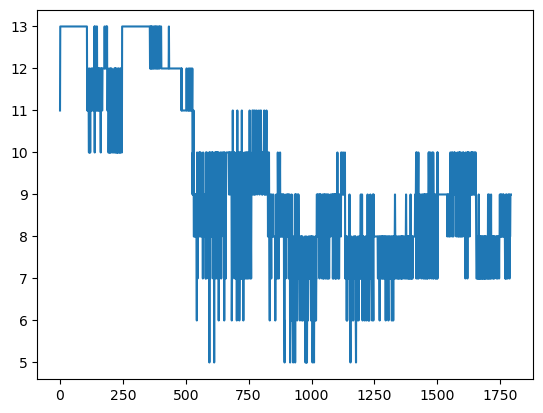

In [48]:
plt.plot(onp.arange(args["n"]), ground_truth_torch)

In [49]:
# Training data is 100 points in [0,1] inclusive regularly spaced

#indices = torch.linspace(0, 98, 50, dtype=int)

train_xs = [args["x"][indices] for indices in obs_idx_lst]

train_plot_xs = [indices/ args["n"] for indices in obs_idx_lst]
# True function is sin(2*pi*x) with Gaussian noise
train_ys = [ground_truth_torch[indices] for indices in obs_idx_lst]

tensor([[6.9315e-01, 1.6715e-02, 1.6390e-02,  ..., 1.3024e-09, 2.6031e-09,
         1.7924e-09],
        [1.6715e-02, 6.9315e-01, 6.9187e-01,  ..., 6.4809e-05, 1.1179e-04,
         8.5819e-05],
        [1.6390e-02, 6.9187e-01, 6.9315e-01,  ..., 5.3474e-05, 9.2873e-05,
         7.1109e-05],
        ...,
        [1.3024e-09, 6.4809e-05, 5.3474e-05,  ..., 6.9315e-01, 6.8714e-01,
         6.9129e-01],
        [2.6031e-09, 1.1179e-04, 9.2873e-05,  ..., 6.8714e-01, 6.9315e-01,
         6.9178e-01],
        [1.7924e-09, 8.5819e-05, 7.1109e-05,  ..., 6.9129e-01, 6.9178e-01,
         6.9315e-01]], grad_fn=<MulBackward0>)
torch.Size([1794])
Done
tensor(0.1479) tensor(0.3540)


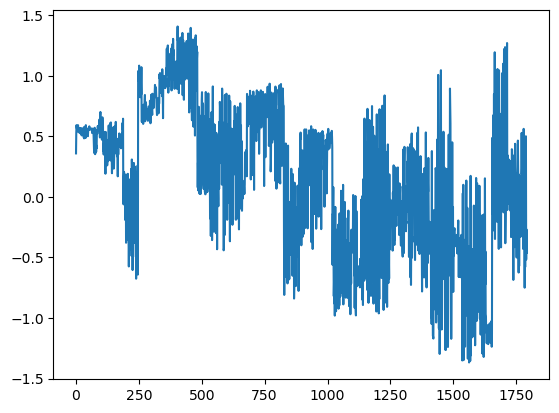

In [50]:
N=1000

test_x = torch.randn((args["n"], N))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
sample_model = ExactGPModel(args["x"], ground_truth_torch, likelihood)

hypers = {
    # We won't be using the likelihood so we don't need to initialize the noise
    'covar_module.base_kernel.lengthscale': torch.tensor([1.0]),
    'covar_module.outputscale': torch.tensor(4.0),
}

sample_model.initialize()#**hypers)

sample_model.eval()
    

with gpytorch.settings.prior_mode(True):
    output_dist = sample_model(args["x"])
    print(output_dist.covariance_matrix)
    sample = output_dist.sample() # torch.linspace(0, 1, N).size()\


print(sample.shape)

plt.plot(onp.arange(0, args["n"]), sample )
print("Done")

print(sample.mean(), sample.var())

In [51]:
def train_model(train_x, train_y, training_iter=1000):
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 100 ==0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

    return model, likelihood

In [57]:
def evaluate_model(model, likelihood, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        print(model(test_x).covariance_matrix)
        observed_pred = likelihood(model(test_x))
    with torch.no_grad():
        # Initialize plot

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
    return observed_pred.mean.numpy(), lower.numpy(), upper.numpy()


def plot_evaluations(train_xs, train_ys, test_x, observed_means, lowers, uppers, max_per_row=2):
    assert len(observed_means) == len(lowers) and len(lowers) == len(uppers)

    num_per_row = min(max_per_row, len(observed_means))
    num_rows = (len(observed_means) + num_per_row -1) // num_per_row


    f, axs = plt.subplots(num_rows, num_per_row, figsize=(num_per_row *10, num_rows * 6))
    
    for i in range(len(observed_means)):
        # Plot training data as black stars
        axs.flat[i].plot(train_xs[i], train_ys[i], 'k*')
        # Plot predictive means as blue line
        axs.flat[i].plot(test_x, observed_means[i], 'b')

        axs.flat[i].plot(test_x, ground_truth, 'r')
        # Shade between the lower and upper confidence bounds
        axs.flat[i].fill_between(test_x, lowers[i], uppers[i], alpha=0.5)
        axs.flat[i].set_ylim([2.5, 15])
        axs.flat[i].legend(['Observed Data', 'Mean', "Ground truth (with noise)", 'Confidence'])
        axs.flat[i].set_title(f"{len(obs_idx_lst[i])} observed points")

In [58]:
means = []
lowers = []
uppers = []

for i in range(len(obs_idx_lst)):
    model, likelihood = train_model(train_xs[i], train_ys[i])

    mean, lower, upper = evaluate_model(model, likelihood, args["x"])
    means.append(mean)
    lowers.append(lower)
    uppers.append(upper)


Iter 1/1000 - Loss: 6.288   lengthscale: 0.693   noise: 0.693
Iter 101/1000 - Loss: 1.513   lengthscale: 1.723   noise: 0.478
Iter 201/1000 - Loss: 1.214   lengthscale: 0.986   noise: 0.272
Iter 301/1000 - Loss: 1.175   lengthscale: 0.962   noise: 0.268
Iter 401/1000 - Loss: 1.168   lengthscale: 0.953   noise: 0.269
Iter 501/1000 - Loss: 1.166   lengthscale: 0.926   noise: 0.268
Iter 601/1000 - Loss: 1.165   lengthscale: 0.907   noise: 0.267
Iter 701/1000 - Loss: 1.165   lengthscale: 0.899   noise: 0.267
Iter 801/1000 - Loss: 1.165   lengthscale: 0.896   noise: 0.267
Iter 901/1000 - Loss: 1.165   lengthscale: 0.895   noise: 0.267
tensor([[ 5.2587e-01,  5.8720e-03,  6.6804e-03,  ..., -3.8861e-05,
         -5.3733e-05, -4.2941e-05],
        [ 5.8720e-03,  3.2858e-02,  3.1969e-02,  ...,  3.0811e-04,
          2.8283e-04,  3.0150e-04],
        [ 6.6804e-03,  3.1969e-02,  3.1939e-02,  ...,  2.2796e-04,
          2.0586e-04,  2.2118e-04],
        ...,
        [-3.8861e-05,  3.0811e-04,  2.27

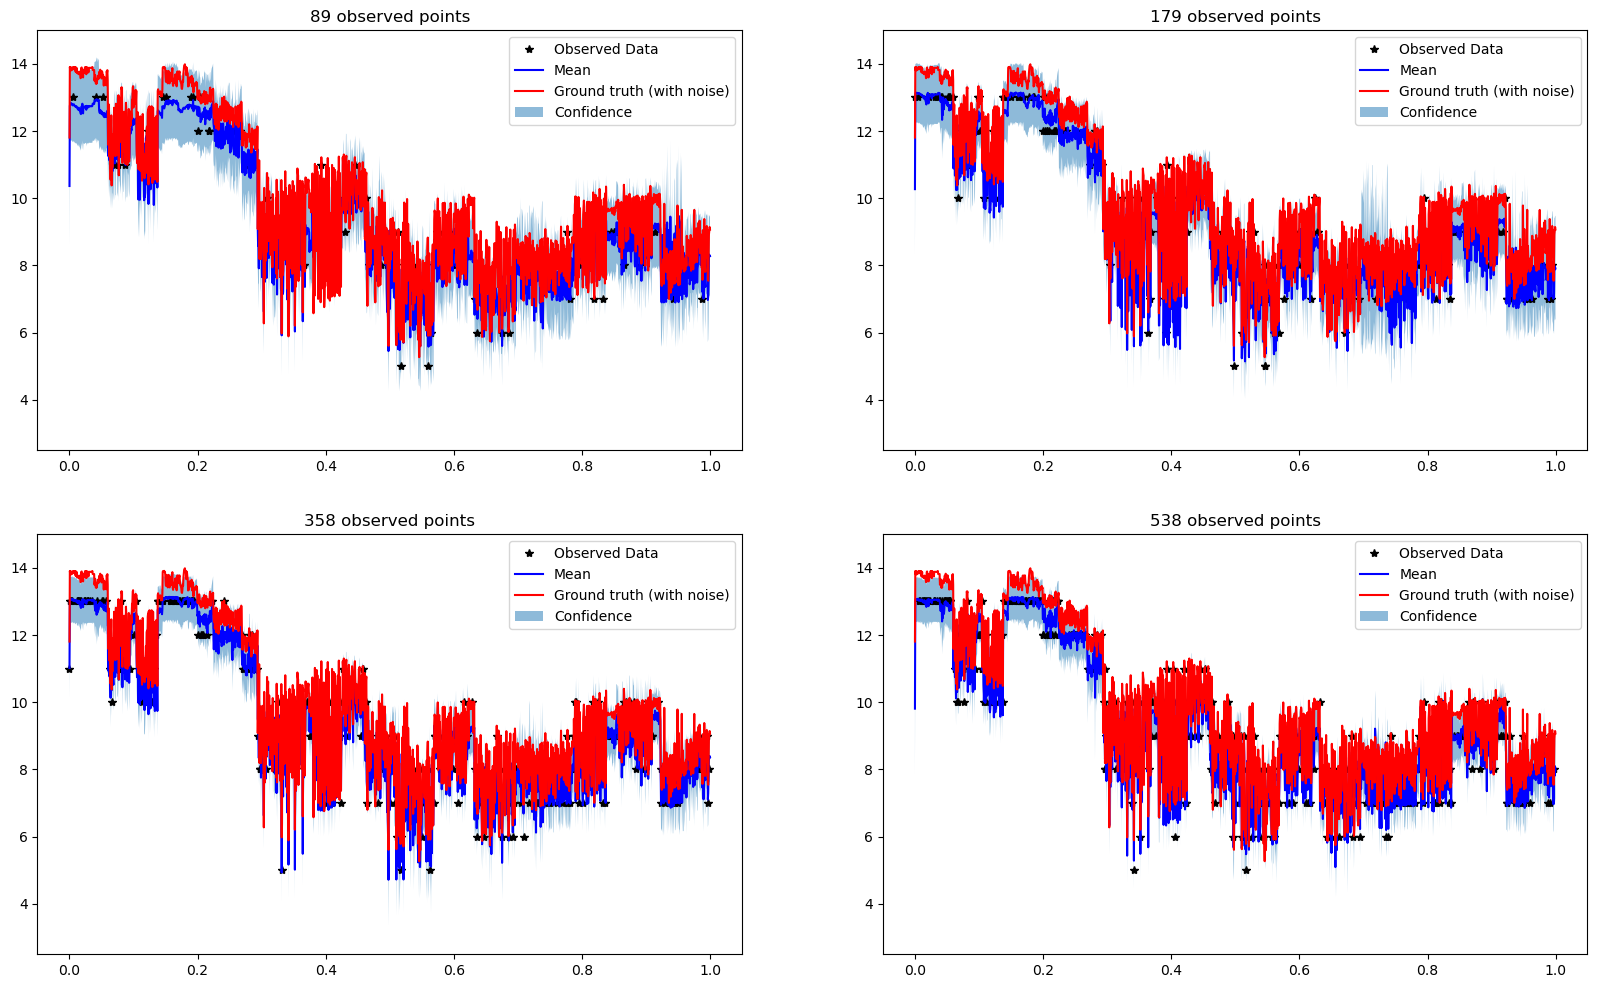

In [59]:

plot_evaluations(train_plot_xs, train_ys, onp.arange(0, 1, 1/args["n"]), means, lowers, uppers)

(1, 5)
[<Axes: title={'center': 'Ground truth'}>, <Axes: title={'center': '89 observed points'}>, <Axes: title={'center': '179 observed points'}>, <Axes: title={'center': '358 observed points'}>, <Axes: title={'center': '538 observed points'}>]


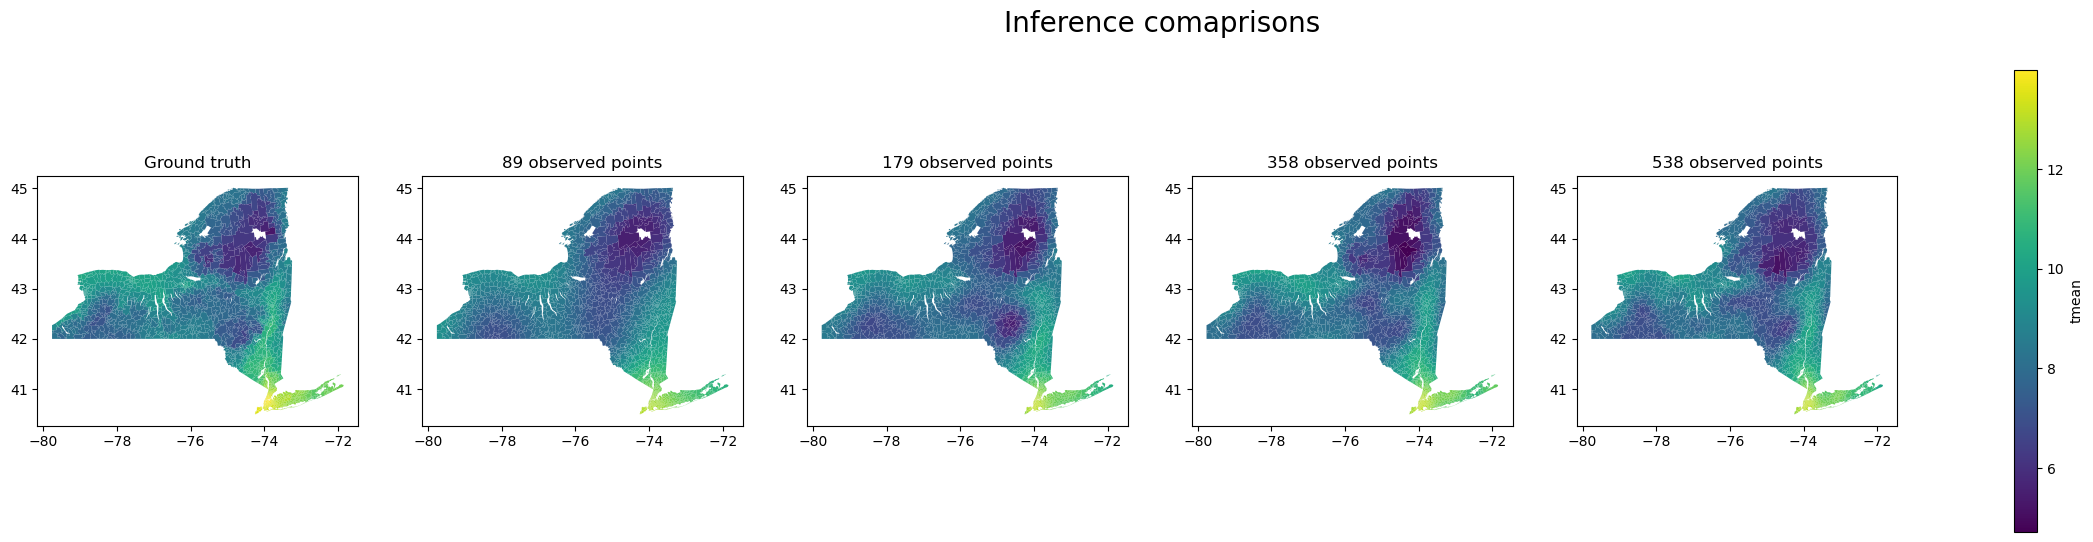

In [84]:
from plotting.ny import plot_multi_on_state


plot_multi_on_state(onp.array([ground_truth] + means), 36, "Inference comaprisons", "tmean", ["Ground truth"] + [f"{len(x)} observed points" for x in obs_idx_lst], num_in_row=5)

In [82]:
masks = []
for x in obs_idx_lst:
    t = torch.zeros(args["n"])
    t[x] = 1
    masks.append(t.numpy())

(1, 4)
[<Axes: title={'center': '89 observed points'}>, <Axes: title={'center': '179 observed points'}>, <Axes: title={'center': '358 observed points'}>, <Axes: title={'center': '538 observed points'}>]
(1, 4)
[<Axes: title={'center': '89: CI differences'}>, <Axes: title={'center': '179: CI differences'}>, <Axes: title={'center': '358: CI differences'}>, <Axes: title={'center': '538: CI differences'}>]


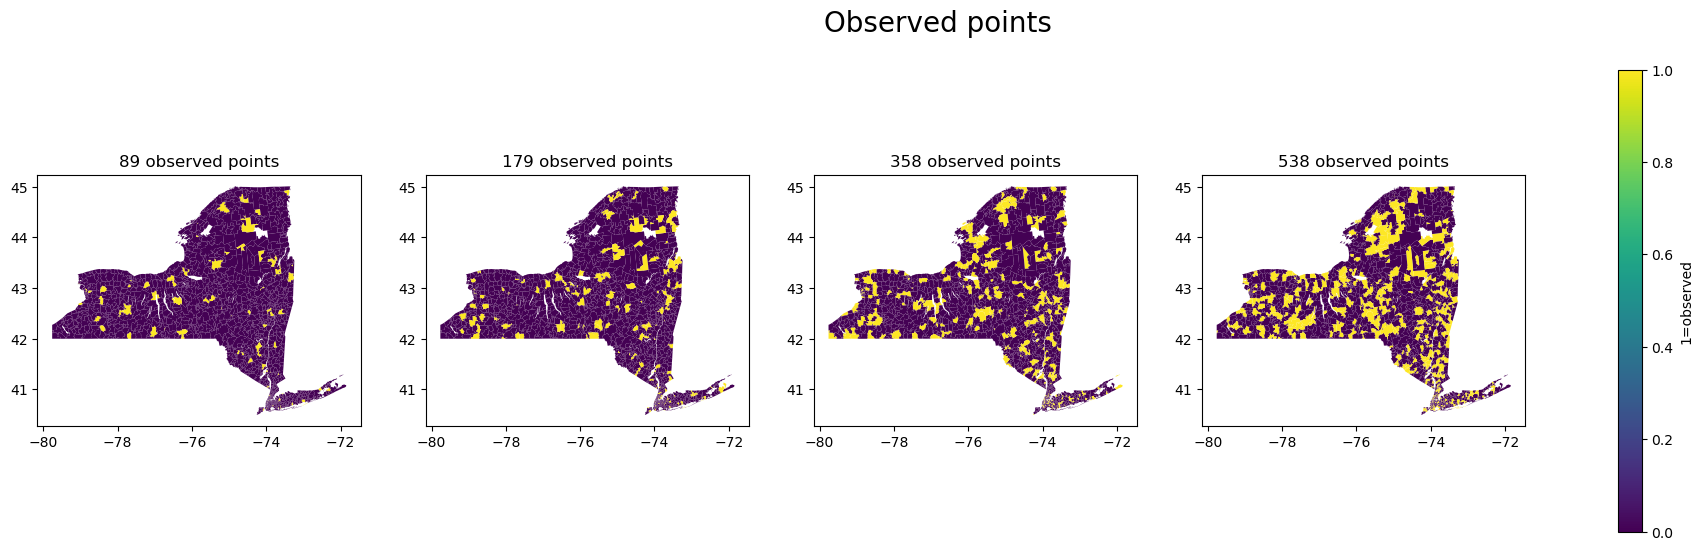

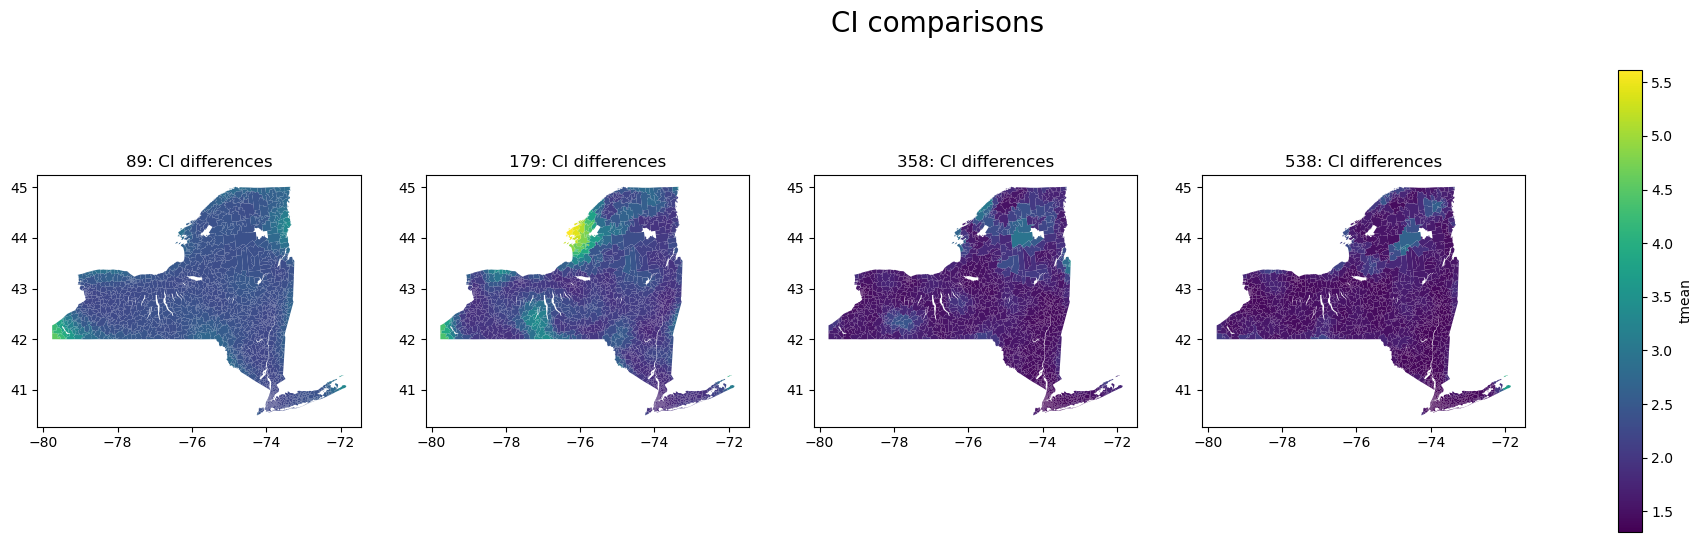

In [83]:

plot_multi_on_state(onp.array(masks), 36, "Observed points", "1=observed", [f"{len(x)} observed points" for x in obs_idx_lst] )
plot_multi_on_state(onp.array([u - l for u,l in zip(uppers, lowers)]), 36, "CI comparisons", "tmean",  [f"{len(x)}: CI differences" for x in obs_idx_lst])